# Imports

In [1]:
import pandas as pd, numpy as np
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
from google.colab import drive
drive.mount('/gdrive')
# %cd /gdrive

Mounted at /gdrive


## Read in data

In [3]:
path = '/gdrive/MyDrive/Springboard/7 Data Wrangling/Capstone 2/train.csv'
df = pd.read_csv(path)

In [4]:
# Id is index, drop this

df = df.drop(columns='Id')

In [5]:
# extract target

y = df['SalePrice'].copy()

In [36]:
# Create skeleton for hyperparamter dictionary

hyperdf = pd.DataFrame()

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import numpy.random as npr

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# set seed for reproducibility and so we can access the indices

npr.seed(seed=0)

# Define regression function

In [32]:
# define function which outputs all info we need when testing new hyperparameters

def regress(X, y, Notes='', k=5, model=LinearRegression()):
  '''
  Fits a model on the features "X" and targets "y"
  default is a LinearRegression model

  uses cross validation

  k: number of folds for cross validation
    default is 5

  X and y are pandas DataFrames

  returns a dictionary with relevant hyperparameters and metrics
  '''

  scores = cross_validate(model, X.copy(), y.copy(), cv=k,
    scoring=('neg_root_mean_squared_error', 'neg_mean_absolute_error'),
    return_train_score=True)

  # create hyperparameter dictionary
  hypers = {'Features':X.columns, '# of features':len(X.columns), \
            'Mean Train MAE':-1*np.mean(scores['train_neg_mean_absolute_error']), \
            'Std Train MAE':np.std(scores['train_neg_mean_absolute_error']), \

            'Mean Test MAE':-1*np.mean(scores['test_neg_mean_absolute_error']), \
            'Std Test MAE':np.std(scores['test_neg_mean_absolute_error']), \

            'Mean Train RMSE':-1*np.mean(scores['train_neg_root_mean_squared_error']), \
            'Std Train RMSE':np.std(scores['train_neg_root_mean_squared_error']), \

            'Mean Test RMSE':-1*np.mean(scores['test_neg_root_mean_squared_error']), \
            'Std Test RMSE':np.std(scores['test_neg_root_mean_squared_error']), \

            "Notes":Notes,
            "Folds":k,

            'Train MAE': -1*scores['train_neg_mean_absolute_error'], \
            'Test MAE': -1*scores['test_neg_mean_absolute_error'], \
            'Train RMSE': -1*scores['train_neg_root_mean_squared_error'], \
            'Test RMSE': -1*scores['test_neg_root_mean_squared_error'], \
            'Model Type':model}

  return hypers

## Numerical Features with Naive handling of NA

- I will extract the numerical/continuous features
  - Analyze the results using the naive approach, i.e. dropping the Garage year built and only filling the NA with 0
  - The smart approach doesn't drop the garage year built but puts 0 for NA and also creates a flag column for each that indicates whether or not NA was present.

In [11]:
# Numerical features where NAs are present

na_cont = ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']

In [12]:
# add a column which is a flag for those continuous features
# that have NA values

for i in na_cont:
  df[i+"_isna"] = df[i].isna()*1

In [13]:
# fill the NA with appropriate values w/in those features now
# we decided that 0 is probably best

df.loc[:, na_cont] = df[na_cont].fillna(0)

In [33]:
# do cross validation on numerical with simple approach
feats = ['MasVnrArea', 'LotFrontage']
X = df[feats].copy()

In [37]:
out = regress(X, y, Notes='Numerical features with naive approach')
out

{'Features': Index(['MasVnrArea', 'LotFrontage'], dtype='object'),
 '# of features': 2,
 'Mean Train MAE': 50917.747951370504,
 'Std Train MAE': 718.7670027488771,
 'Mean Test MAE': 51025.58272739347,
 'Std Test MAE': 2417.6208827950677,
 'Mean Train RMSE': 68771.92856289665,
 'Std Train RMSE': 1143.6560299731857,
 'Mean Test RMSE': 68911.34757402368,
 'Std Test RMSE': 4685.402441436475,
 'Notes': 'Numerical features with naive approach',
 'Folds': 5,
 'Train MAE': array([51374.92005286, 49833.77750448, 50630.65216586, 51965.9253145 ,
        50783.46471915]),
 'Test MAE': array([49139.05525895, 54376.19177995, 52518.11407142, 47567.31957995,
        51527.23294668]),
 'Train RMSE': array([69990.74915738, 67730.88469327, 68081.90550595, 70324.80143936,
        67731.30201852]),
 'Test RMSE': array([64014.98287924, 73129.5117134 , 71959.40121199, 62439.6946608 ,
        73013.1474047 ]),
 'Model Type': LinearRegression()}

In [38]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-38-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()


## Numerical with smart handling of NA

- I.e. don't drop any rows/columns, fill NA with appropriate values (0) and create flag column indicating if NA is present

In [39]:
# do cross validation on numerical with smart approach
feats = [i+'_isna' for i in na_cont] + na_cont
X = df[feats].copy()

In [40]:
out = regress(X, y, Notes='Numerical features with smart approach')
out

{'Features': Index(['GarageYrBlt_isna', 'MasVnrArea_isna', 'LotFrontage_isna',
        'GarageYrBlt', 'MasVnrArea', 'LotFrontage'],
       dtype='object'),
 '# of features': 6,
 'Mean Train MAE': 40996.585532617304,
 'Std Train MAE': 740.5051465743508,
 'Mean Test MAE': 41460.36508821178,
 'Std Test MAE': 1846.014351237355,
 'Mean Train RMSE': 58856.158168780385,
 'Std Train RMSE': 1293.7647535312733,
 'Mean Test RMSE': 59417.08420809782,
 'Std Test RMSE': 5207.8643070770495,
 'Notes': 'Numerical features with smart approach',
 'Folds': 5,
 'Train MAE': array([41422.64043995, 40287.31466612, 40494.79072383, 42254.31702327,
        40523.86480991]),
 'Test MAE': array([40183.65547805, 42768.65591573, 42732.32331695, 38439.02290084,
        43178.1678295 ]),
 'Train RMSE': array([60107.86726986, 58639.82850942, 57685.64916323, 60563.28701784,
        57284.15888355]),
 'Test RMSE': array([54210.89301575, 60584.72409898, 64172.22947382, 52567.51294407,
        65550.06150786]),
 'Model Ty

In [41]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-41-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()


- **Analysis**
- So clearly the smart handling of NA is better

## Single most correlated feature

In [42]:
feats = ['OverallQual']
X = df[feats].copy()

In [43]:
out = regress(X, y, Notes='baseline using single most correlated feature')
out

{'Features': Index(['OverallQual'], dtype='object'),
 '# of features': 1,
 'Mean Train MAE': 33723.23015893879,
 'Std Train MAE': 621.7890215270475,
 'Mean Test MAE': 33766.38485172985,
 'Std Test MAE': 2016.830372104499,
 'Mean Train RMSE': 48565.462618723344,
 'Std Train RMSE': 1107.8151274291026,
 'Mean Test RMSE': 48492.875761167765,
 'Std Test RMSE': 4389.638768623911,
 'Notes': 'baseline using single most correlated feature',
 'Folds': 5,
 'Train MAE': array([34117.10336131, 33290.29729853, 32920.44699954, 34688.08654063,
        33600.21659468]),
 'Test MAE': array([32087.02626683, 35617.89568103, 36148.95190307, 30884.38115495,
        34093.66925277]),
 'Train RMSE': array([49840.22992042, 48617.94154897, 46851.47973781, 49623.6910872 ,
        47893.97079922]),
 'Test RMSE': array([43226.91783631, 48486.47097997, 55105.99702205, 44359.68699252,
        51285.30597499]),
 'Model Type': LinearRegression()}

In [44]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-44-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()


- **Analysis**

- Clearly the single most correlated feature is the best so far

## Take top two correlated features

In [45]:
feats = ['OverallQual', 'GrLivArea']
X = df[feats].copy()
X.head()

,OverallQual,GrLivArea
0,7,1710
1,6,1262
2,7,1786
3,7,1717
4,8,2198


In [46]:
out = regress(X, y, Notes='2 highest correlated features')
out

{'Features': Index(['OverallQual', 'GrLivArea'], dtype='object'),
 '# of features': 2,
 'Mean Train MAE': 28757.65839312739,
 'Std Train MAE': 374.908529717655,
 'Mean Test MAE': 28912.79589837091,
 'Std Test MAE': 1365.1129217892912,
 'Mean Train RMSE': 42409.03868117311,
 'Std Train RMSE': 1010.3345456925905,
 'Mean Test RMSE': 42586.99465851458,
 'Std Test RMSE': 4178.400538681416,
 'Notes': '2 highest correlated features',
 'Folds': 5,
 'Train MAE': array([29184.44455191, 28610.96549622, 28384.45045197, 29225.81830502,
        28382.61316053]),
 'Test MAE': array([27112.36085918, 29629.55089524, 29304.21437303, 27651.20454686,
        30866.64881754]),
 'Train RMSE': array([43716.16115588, 42333.18113754, 41752.13876271, 43303.6114062 ,
        40940.10094354]),
 'Test RMSE': array([37003.44813403, 42963.79399946, 45636.04954018, 38956.66720532,
        48375.01441358]),
 'Model Type': LinearRegression()}

In [47]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-47-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,28913.0,1365.0,42409.0,1010.0,42587.0,4178.0,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()


- **Analysis**

- Top two are best so far

## All numerical/continuous features

In [48]:
feats = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'GarageYrBlt_isna', 'MasVnrArea_isna',
'LotFrontage_isna', 'GarageYrBlt', 'MasVnrArea', 'LotFrontage']

X = df[feats].copy()
X.head()

,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrBlt_isna,MasVnrArea_isna,LotFrontage_isna,GarageYrBlt,MasVnrArea,LotFrontage
0,8450,2003,2003,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,2,2008,0,0,0,2003.0,196.0,65.0
1,9600,1976,1976,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,5,2007,0,0,0,1976.0,0.0,80.0
2,11250,2001,2002,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,9,2008,0,0,0,2001.0,162.0,68.0
3,9550,1915,1970,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,2,2006,0,0,0,1998.0,0.0,60.0
4,14260,2000,2000,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,12,2008,0,0,0,2000.0,350.0,84.0


In [49]:
out = regress(X, y, Notes='all numerical/continuous')
out

{'Features': Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
        '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'GarageYrBlt_isna', 'MasVnrArea_isna', 'LotFrontage_isna',
        'GarageYrBlt', 'MasVnrArea', 'LotFrontage'],
       dtype='object'),
 '# of features': 27,
 'Mean Train MAE': 24043.11176035402,
 'Std Train MAE': 681.3482877485919,
 'Mean Test MAE': 25003.399745349892,
 'Std Test MAE': 1952.4051379565053,
 'Mean Train RMSE': 39439.527465965,
 'Std Train RMSE': 2211.841618472792,
 'Mean Test RMSE': 41224.741665438356,
 'Std Test RMSE': 8077.95590917981,
 'Notes': 'all numerical/continuous',
 'Folds': 5,
 'Train MAE': array([24304.99337446, 24301.63041381, 24059.25431674, 24785.17788826,
        22764.50280849]),
 'Test MAE': array([24943.18342694, 24447.709994

In [50]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-50-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,28913.0,1365.0,42409.0,1010.0,42587.0,4178.0,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,25003.0,1952.0,39440.0,2212.0,41225.0,8078.0,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()


- **Analysis**

- All numerical are best so far

## Create ordinal

- Do some work on the categoricals that we think are ordinal, or at least can be

- Will compare this approach, i.e. creating ordinal out of the features vs one hot encoding and basically treating as categorical

In [51]:
ordinals = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
            'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
            'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
            'FireplaceQu', 'GarageCars', 'PavedDrive', 'BsmtFinType1',
            'BsmtQual', 'BsmtCond', 'BsmtFinType2', 'BsmtExposure',
            'GarageQual', 'GarageFinish', 'GarageCond']

In [52]:
df[ordinals].describe()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,5.575342,0.425342,0.057534,1.565068,0.382877,6.517808,0.613014,1.767123
std,1.382997,1.112799,0.518911,0.238753,0.550916,0.502885,1.625393,0.644666,0.747315
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,5.000000,5.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000,1.000000
50%,6.000000,5.000000,0.000000,0.000000,2.000000,0.000000,6.000000,1.000000,2.000000
75%,7.000000,6.000000,1.000000,0.000000,2.000000,1.000000,7.000000,1.000000,2.000000
max,10.000000,9.000000,3.000000,2.000000,3.000000,2.000000,14.000000,3.000000,4.000000


In [53]:
# extract string ordinals

string_ords = list(set(ordinals).difference(set(df[ordinals].describe().columns)))
string_ords

['FireplaceQu',
 'GarageQual',
 'BsmtFinType2',
 'HeatingQC',
 'BsmtFinType1',
 'GarageFinish',
 'GarageCond',
 'KitchenQual',
 'PavedDrive',
 'Functional',
 'ExterQual',
 'BsmtExposure',
 'BsmtCond',
 'BsmtQual',
 'ExterCond']

In [54]:
df[string_ords]

,FireplaceQu,GarageQual,BsmtFinType2,HeatingQC,BsmtFinType1,GarageFinish,GarageCond,KitchenQual,PavedDrive,Functional,ExterQual,BsmtExposure,BsmtCond,BsmtQual,ExterCond
0,NaN,TA,Unf,Ex,GLQ,RFn,TA,Gd,Y,Typ,Gd,No,TA,Gd,TA
1,TA,TA,Unf,Ex,ALQ,RFn,TA,TA,Y,Typ,TA,Gd,TA,Gd,TA
2,TA,TA,Unf,Ex,GLQ,RFn,TA,Gd,Y,Typ,Gd,Mn,TA,Gd,TA
3,Gd,TA,Unf,Gd,ALQ,Unf,TA,Gd,Y,Typ,TA,No,Gd,TA,TA
4,TA,TA,Unf,Ex,GLQ,RFn,TA,Gd,Y,Typ,Gd,Av,TA,Gd,TA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TA,TA,Unf,Ex,Unf,RFn,TA,TA,Y,Typ,TA,No,TA,Gd,TA
1456,TA,TA,Rec,TA,ALQ,Unf,TA,TA,Y,Min1,TA,No,TA,Gd,TA
1457,Gd,TA,Unf,Ex,GLQ,RFn,TA,Gd,Y,Typ,Ex,No,Gd,TA,Gd
1458,NaN,TA,Rec,Gd,GLQ,Unf,TA,Gd,Y,Typ,TA,Mn,TA,TA,TA


In [55]:
# Create copy so we can one hot encode them later
df2 = df.copy()

In [56]:
# Create mappings per the metadata to go from strings to ordinal (numbers)

ExterQual = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}
df2['ExterQual'] = df2['ExterQual'].apply(lambda x: ExterQual[x])

# Create mappings per the metadata to go from strings to ordinal (numbers)

HeatingQC = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}

df2['HeatingQC'] = df2['HeatingQC'].apply(lambda x: HeatingQC[x])

# Create mappings per the metadata to go from strings to ordinal (numbers)

KitchenQual = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}

df2['KitchenQual'] = df2['KitchenQual'].apply(lambda x: KitchenQual[x])
df2['KitchenQual']
# Create mappings per the metadata to go from strings to ordinal (numbers)

ExterCond = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}

df2['ExterCond'] = df2['ExterCond'].apply(lambda x: ExterCond[x])
df2['ExterCond']
# Create mappings per the metadata to go from strings to ordinal (numbers)

FireplaceQu = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, np.nan:0}

df2['FireplaceQu'] = df2['FireplaceQu'].apply(lambda x: FireplaceQu[x])
df2['FireplaceQu']
# Create mappings per the metadata to go from strings to ordinal (numbers)

PavedDrive = {'Y':2, 'P': 1, 'N': 0}

df2['PavedDrive'] = df2['PavedDrive'].apply(lambda x: PavedDrive[x])
df2['PavedDrive']
# Create mappings per the metadata to go from strings to ordinal (numbers)

Functional = {'Typ':8, 'Min1': 7, 'Min2': 6, 'Mod':5, 'Maj1':4, 'Maj2':3,
              'Sev':2, 'Sal':1}

df2['Functional'] = df2['Functional'].apply(lambda x: Functional[x])
df2['Functional']
# Define maps for the remaining

BsmtFinType1 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, np.nan:1}

BsmtQual = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, np.nan:0}

BsmtCond = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, np.nan:0}

BsmtFinType2 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, np.nan:1}

BsmtExposure = {'Gd':5, 'Av':4, 'Mn':3, 'No':2, np.nan:1}

GarageQual = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, np.nan:0}

GarageFinish = {'Fin':4, 'RFn':3, 'Unf':2, np.nan:1}

GarageCond = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, np.nan:0}
# alter data

df2['BsmtFinType1'] = df2['BsmtFinType1'].apply(lambda x: BsmtFinType1[x])

df2['BsmtQual'] = df2['BsmtQual'].apply(lambda x: BsmtQual[x])

df2['BsmtCond'] = df2['BsmtCond'].apply(lambda x: BsmtCond[x])

df2['BsmtFinType2'] = df2['BsmtFinType2'].apply(lambda x: BsmtFinType2[x])

df2['BsmtExposure'] = df2['BsmtExposure'].apply(lambda x: BsmtExposure[x])

df2['GarageQual'] = df2['GarageQual'].apply(lambda x: GarageQual[x])

df2['GarageFinish'] = df2['GarageFinish'].apply(lambda x: GarageFinish[x])

df2['GarageCond'] = df2['GarageCond'].apply(lambda x: GarageCond[x])

In [57]:
feats = ordinals
X = df2[feats].copy()
X.head()

,OverallQual,OverallCond,ExterQual,ExterCond,HeatingQC,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,BsmtFinType1,BsmtQual,BsmtCond,BsmtFinType2,BsmtExposure,GarageQual,GarageFinish,GarageCond
0,7,5,4,3,5,1,0,2,1,4,8,8,0,0,2,2,7,4,3,2,2,3,3,3
1,6,8,3,3,5,0,1,2,0,3,6,8,1,3,2,2,6,4,3,2,5,3,3,3
2,7,5,4,3,5,1,0,2,1,4,6,8,1,3,2,2,7,4,3,2,3,3,3,3
3,7,5,3,3,4,1,0,1,0,4,7,8,1,4,3,2,6,3,4,2,2,3,2,3
4,8,5,4,3,5,1,0,2,1,4,9,8,1,3,3,2,7,4,3,2,4,3,3,3


In [58]:
out = regress(X, y, Notes='all ordinal')
out

{'Features': Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars',
        'PavedDrive', 'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'BsmtFinType2',
        'BsmtExposure', 'GarageQual', 'GarageFinish', 'GarageCond'],
       dtype='object'),
 '# of features': 24,
 'Mean Train MAE': 24834.794183633865,
 'Std Train MAE': 400.71291688215314,
 'Mean Test MAE': 25300.574451030727,
 'Std Test MAE': 1143.5402033738021,
 'Mean Train RMSE': 36741.847592331025,
 'Std Train RMSE': 1206.1775875613891,
 'Mean Test RMSE': 37205.265480688904,
 'Std Test RMSE': 4808.617688810368,
 'Notes': 'all ordinal',
 'Folds': 5,
 'Train MAE': array([25208.36991516, 24815.44512515, 24186.7334379 , 25297.75633878,
        24665.66610118]),
 'Test MAE': array([23835.9422532 , 25532.52953048, 26777.47294941, 24146.8584261 ,
        26210.0690

In [59]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-59-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,28913.0,1365.0,42409.0,1010.0,42587.0,4178.0,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,25003.0,1952.0,39440.0,2212.0,41225.0,8078.0,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,25301.0,1144.0,36742.0,1206.0,37205.0,4809.0,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()


- **Analysis**

- All Numerical is better than Ordinal on MAE on train and test but the Standard deviation of Ordinal is lower on train and test for MAE and RMSE and mean of train/test is lower for Ordinal.

- Winner so far:
  - *Ordinal*

## Treat ordinals as categorical

In [60]:
X = pd.get_dummies(df[ordinals], dummy_na=True)
X.head()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HeatingQC_nan,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_nan,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Functional_nan,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_nan,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_nan,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_nan,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_nan,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_nan
0,7,5,1,0,2,1,8,0,2,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,6,8,0,1,2,0,6,1,2,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
2,7,5,1,0,2,1,6,1,2,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,7,5,1,0,1,0,7,1,3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,8,5,1,0,2,1,9,1,3,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [61]:
out = regress(X, y, Notes='Ordinals treated as categorical, one hot encode')
out

{'Features': Index(['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA',
        'ExterQual_nan', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd',
        'ExterCond_Po', 'ExterCond_TA', 'ExterCond_nan', 'HeatingQC_Ex',
        'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA',
        'HeatingQC_nan', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd',
        'KitchenQual_TA', 'KitchenQual_nan', 'Functional_Maj1',
        'Functional_Maj2', 'Functional_Min1', 'Functional_Min2',
        'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'Functional_nan',
        'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po',
        'FireplaceQu_TA', 'FireplaceQu_nan', 'PavedDrive_N', 'PavedDrive_P',
        'PavedDrive_Y', 'PavedDrive_nan', 'BsmtFinType1_ALQ',
        'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ

In [62]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-62-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,5.102600e+04,2.418000e+03,68772.0,1144.0,6.891100e+04,4.685000e+03,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,4.146000e+04,1.846000e+03,58856.0,1294.0,5.941700e+04,5.208000e+03,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,3.376600e+04,2.017000e+03,48565.0,1108.0,4.849300e+04,4.390000e+03,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,2.891300e+04,1.365000e+03,42409.0,1010.0,4.258700e+04,4.178000e+03,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,2.500300e+04,1.952000e+03,39440.0,2212.0,4.122500e+04,8.078000e+03,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,2.530100e+04,1.144000e+03,36742.0,1206.0,3.720500e+04,4.809000e+03,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
6,"Index(['OverallQual', 'OverallCond', 'BsmtFull...",94,22396.0,342.0,9.594627e+12,1.410297e+13,33817.0,1278.0,1.095776e+14,1.359605e+14,"Ordinals treated as categorical, one hot encode",5,"[22758.411922089042, 22342.914383561645, 22068...","[1055977366767.6978, 37524641172026.45, 385085...","[35368.802968754404, 33833.56550831049, 33022....","[14627242355683.562, 372761509608161.8, 658033...",LinearRegression()


- **Analysis**

- Leaving Ordinals as ordinals seems to be better as the test for our scores was really high but this may be an issue of sample size.

- We will come back to this as the train set is better this way

## Combine both ordinal setups

In [63]:
# ordinals used as actual ordinals
t1 = df2[ordinals].copy()

# ordinals treated as categoricals with one hot encoding
t2 = pd.get_dummies(df[ordinals], dummy_na=True)

- couldn't find a workaround because there's duplicate values in the columns that exist in both frames

- reference https://stackoverflow.com/questions/22720739/pandas-left-outer-join-results-in-table-larger-than-left-table


In [64]:
# extract columns that are in 2nd but not in first

left_cols = list(set(t2.columns).difference(set(t1.columns)))

In [65]:
X = pd.concat([t1, t2[left_cols]], axis=1)

In [66]:
out = regress(X, y, Notes='Both ordinals setups')
out

{'Features': Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual',
        ...
        'GarageCond_Gd', 'GarageCond_TA', 'Functional_Mod', 'GarageQual_nan',
        'BsmtExposure_Mn', 'BsmtQual_TA', 'ExterQual_TA', 'BsmtFinType1_Unf',
        'GarageCond_Po', 'ExterQual_Fa'],
       dtype='object', length=109),
 '# of features': 109,
 'Mean Train MAE': 22397.316438356163,
 'Std Train MAE': 343.25074240721653,
 'Mean Test MAE': 23318812914748.832,
 'Std Test MAE': 31482033999249.676,
 'Mean Train RMSE': 33816.811978157624,
 'Std Train RMSE': 1277.6586894897825,
 'Mean Test RMSE': 253543381750044.56,
 'Std Test RMSE': 276488666571697.97,
 'Notes': 'Both ordinals setups',
 'Folds': 5,
 'Train MAE': array([22759.97859589, 22344.21575342, 22069.7380137 , 22823.03339041,
        21989.61643836]),
 'Test MAE': array([1.04313212e+13, 8.52800450e+13, 4.32230432e+12, 1.65603941e+13,
        2.460

In [67]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-67-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,5.102600e+04,2.418000e+03,68772.0,1144.0,6.891100e+04,4.685000e+03,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,4.146000e+04,1.846000e+03,58856.0,1294.0,5.941700e+04,5.208000e+03,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,3.376600e+04,2.017000e+03,48565.0,1108.0,4.849300e+04,4.390000e+03,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,2.891300e+04,1.365000e+03,42409.0,1010.0,4.258700e+04,4.178000e+03,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,2.500300e+04,1.952000e+03,39440.0,2212.0,4.122500e+04,8.078000e+03,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,2.530100e+04,1.144000e+03,36742.0,1206.0,3.720500e+04,4.809000e+03,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
6,"Index(['OverallQual', 'OverallCond', 'BsmtFull...",94,22396.0,342.0,9.594627e+12,1.410297e+13,33817.0,1278.0,1.095776e+14,1.359605e+14,"Ordinals treated as categorical, one hot encode",5,"[22758.411922089042, 22342.914383561645, 22068...","[1055977366767.6978, 37524641172026.45, 385085...","[35368.802968754404, 33833.56550831049, 33022....","[14627242355683.562, 372761509608161.8, 658033...",LinearRegression()
7,"Index(['OverallQual', 'OverallCond', 'ExterQua...",109,22397.0,343.0,2.331881e+13,3.148203e+13,33817.0,1278.0,2.535434e+14,2.764887e+14,Both ordinals setups,5,"[22759.97859589041, 22344.215753424658, 22069....","[10431321174750.576, 85280044998537.6, 4322304...","[35368.869618304554, 33833.77895346986, 33023....","[136633455563292.0, 774239747676828.8, 7385956...",LinearRegression()


- **Analysis**

- Combining categorical and ordinal variables hasn't helped it seems

## All continuous and ordinal
  - We'll take the ordinal as actual ordinal here as well

In [68]:
# Now create new list with all numerical features

all_nums = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'GarageYrBlt_isna', 'MasVnrArea_isna',
'LotFrontage_isna', 'GarageYrBlt', 'MasVnrArea', 'LotFrontage']

# ordinals used as actual ordinals
t1 = df2[ordinals].copy()

# nums_and_ords = all_nums + all_ords

In [69]:
X = pd.concat([t1, df[all_nums]], axis=1)

In [70]:
out = regress(X, y, Notes='all continuous and ordinal')
out

{'Features': Index(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenQual',
        'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars',
        'PavedDrive', 'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'BsmtFinType2',
        'BsmtExposure', 'GarageQual', 'GarageFinish', 'GarageCond', 'LotArea',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'GarageYrBlt_isna', 'MasVnrArea_isna', 'LotFrontage_isna',
        'GarageYrBlt', 'MasVnrArea', 'LotFrontage'],
       dtype='object'),
 '# of features': 51,
 'Mean Train MAE': 20457.725683853816,
 'Std Train MAE': 645.9024650712269,
 'Mean Test MAE': 21577.97983057852,
 'Std Test MAE

In [71]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-71-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,5.102600e+04,2.418000e+03,68772.0,1144.0,6.891100e+04,4.685000e+03,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,4.146000e+04,1.846000e+03,58856.0,1294.0,5.941700e+04,5.208000e+03,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,3.376600e+04,2.017000e+03,48565.0,1108.0,4.849300e+04,4.390000e+03,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,2.891300e+04,1.365000e+03,42409.0,1010.0,4.258700e+04,4.178000e+03,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,2.500300e+04,1.952000e+03,39440.0,2212.0,4.122500e+04,8.078000e+03,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,2.530100e+04,1.144000e+03,36742.0,1206.0,3.720500e+04,4.809000e+03,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
6,"Index(['OverallQual', 'OverallCond', 'BsmtFull...",94,22396.0,342.0,9.594627e+12,1.410297e+13,33817.0,1278.0,1.095776e+14,1.359605e+14,"Ordinals treated as categorical, one hot encode",5,"[22758.411922089042, 22342.914383561645, 22068...","[1055977366767.6978, 37524641172026.45, 385085...","[35368.802968754404, 33833.56550831049, 33022....","[14627242355683.562, 372761509608161.8, 658033...",LinearRegression()
7,"Index(['OverallQual', 'OverallCond', 'ExterQua...",109,22397.0,343.0,2.331881e+13,3.148203e+13,33817.0,1278.0,2.535434e+14,2.764887e+14,Both ordinals setups,5,"[22759.97859589041, 22344.215753424658, 22069....","[10431321174750.576, 85280044998537.6, 4322304...","[35368.869618304554, 33833.77895346986, 33023....","[136633455563292.0, 774239747676828.8, 7385956...",LinearRegression()
8,"Index(['OverallQual', 'OverallCond', 'ExterQua...",51,20458.0,646.0,2.157800e+04,9.580000e+02,32829.0,1767.0,3.533900e+04,7.288000e+03,all continuous and ordinal,5,"[20868.521786576137, 20630.99268969516, 20394....","[21017.799085718852, 21716.91604140758, 21954....","[34608.3403496537, 32940.37976496939, 32841.81...","[27621.46642685809, 35039.15781654459, 36001.9...",LinearRegression()


- **Analysis**

- We have a new winner

## Top 10 correlations

In [72]:
df3 = pd.concat([t1, df[all_nums]], axis=1)

In [73]:
nums_and_ords = df3.columns

In [74]:
# create series of correlations of each numeric feature with target
correlations = pd.Series({i: df3[i].corr(y) for i in nums_and_ords})

In [75]:
top_ten = correlations.sort_values(ascending=False)[:10].index
top_ten

Index(['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath'],
      dtype='object')

In [76]:
feats = top_ten
X = df3[feats].copy()
X.head()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath
0,7,1710,4,4,2,548,856,856,4,2
1,6,1262,3,3,2,460,1262,1262,4,2
2,7,1786,4,4,2,608,920,920,4,2
3,7,1717,3,4,3,642,756,961,3,1
4,8,2198,4,4,3,836,1145,1145,4,2


In [77]:
out = regress(X, y, Notes='top 10 features by correlation')
out

{'Features': Index(['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars',
        'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath'],
       dtype='object'),
 '# of features': 10,
 'Mean Train MAE': 23486.733155147514,
 'Std Train MAE': 434.56818332935137,
 'Mean Test MAE': 23857.873696093193,
 'Std Test MAE': 1124.16970819788,
 'Mean Train RMSE': 36525.36607452608,
 'Std Train RMSE': 1443.8936533900053,
 'Mean Test RMSE': 37435.20661914353,
 'Std Test RMSE': 6057.965302425597,
 'Notes': 'top 10 features by correlation',
 'Folds': 5,
 'Train MAE': array([23926.51005114, 23492.65399393, 23409.23193381, 23884.45015247,
        22720.81964439]),
 'Test MAE': array([22236.15590435, 24521.37354911, 23798.75061853, 23198.72570311,
        25534.36270536]),
 'Train RMSE': array([38247.29409879, 36441.23648663, 36236.68247397, 37647.83910459,
        34053.77820865]),
 'Test RMSE': array([29791.46036793, 37875.09972239, 39301.08231233, 32784.84217923,
        4742

In [78]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-78-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,5.102600e+04,2.418000e+03,68772.0,1144.0,6.891100e+04,4.685000e+03,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,4.146000e+04,1.846000e+03,58856.0,1294.0,5.941700e+04,5.208000e+03,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,3.376600e+04,2.017000e+03,48565.0,1108.0,4.849300e+04,4.390000e+03,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,2.891300e+04,1.365000e+03,42409.0,1010.0,4.258700e+04,4.178000e+03,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,2.500300e+04,1.952000e+03,39440.0,2212.0,4.122500e+04,8.078000e+03,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,2.530100e+04,1.144000e+03,36742.0,1206.0,3.720500e+04,4.809000e+03,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
6,"Index(['OverallQual', 'OverallCond', 'BsmtFull...",94,22396.0,342.0,9.594627e+12,1.410297e+13,33817.0,1278.0,1.095776e+14,1.359605e+14,"Ordinals treated as categorical, one hot encode",5,"[22758.411922089042, 22342.914383561645, 22068...","[1055977366767.6978, 37524641172026.45, 385085...","[35368.802968754404, 33833.56550831049, 33022....","[14627242355683.562, 372761509608161.8, 658033...",LinearRegression()
7,"Index(['OverallQual', 'OverallCond', 'ExterQua...",109,22397.0,343.0,2.331881e+13,3.148203e+13,33817.0,1278.0,2.535434e+14,2.764887e+14,Both ordinals setups,5,"[22759.97859589041, 22344.215753424658, 22069....","[10431321174750.576, 85280044998537.6, 4322304...","[35368.869618304554, 33833.77895346986, 33023....","[136633455563292.0, 774239747676828.8, 7385956...",LinearRegression()
8,"Index(['OverallQual', 'OverallCond', 'ExterQua...",51,20458.0,646.0,2.157800e+04,9.580000e+02,32829.0,1767.0,3.533900e+04,7.288000e+03,all continuous and ordinal,5,"[20868.521786576137, 20630.99268969516, 20394....","[21017.799085718852, 21716.91604140758, 21954....","[34608.3403496537, 32940.37976496939, 32841.81...","[27621.46642685809, 35039.15781654459, 36001.9...",LinearRegression()
9,"Index(['OverallQual', 'GrLivArea', 'ExterQual'...",10,23487.0,435.0,2.385800e+04,1.124000e+03,36525.0,1444.0,3.743500e+04,6.058000e+03,top 10 features by correlation,5,"[23926.510051139394, 23492.653993932792, 23409.

- **Analysis**

- Only slightly worse than all continuous and ordinal features combined

In [79]:
feats = nums_and_ords
X = df[feats].copy()
X.head()

,OverallQual,OverallCond,ExterQual,ExterCond,HeatingQC,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,BsmtFinType1,BsmtQual,BsmtCond,BsmtFinType2,BsmtExposure,GarageQual,GarageFinish,GarageCond,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrBlt_isna,MasVnrArea_isna,LotFrontage_isna,GarageYrBlt,MasVnrArea,LotFrontage
0,7,5,Gd,TA,Ex,1,0,2,1,Gd,8,Typ,0,NaN,2,Y,GLQ,Gd,TA,Unf,No,TA,RFn,TA,8450,2003,2003,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,2,2008,0,0,0,2003.0,196.0,65.0
1,6,8,TA,TA,Ex,0,1,2,0,TA,6,Typ,1,TA,2,Y,ALQ,Gd,TA,Unf,Gd,TA,RFn,TA,9600,1976,1976,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,5,2007,0,0,0,1976.0,0.0,80.0
2,7,5,Gd,TA,Ex,1,0,2,1,Gd,6,Typ,1,TA,2,Y,GLQ,Gd,TA,Unf,Mn,TA,RFn,TA,11250,2001,2002,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,9,2008,0,0,0,2001.0,162.0,68.0
3,7,5,TA,TA,Gd,1,0,1,0,Gd,7,Typ,1,Gd,3,Y,ALQ,TA,Gd,Unf,No,TA,Unf,TA,9550,1915,1970,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,2,2006,0,0,0,1998.0,0.0,60.0
4,8,5,Gd,TA,Ex,1,0,2,1,Gd,9,Typ,1,TA,3,Y,GLQ,Gd,TA,Unf,Av,TA,RFn,TA,14260,2000,2000,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,12,2008,0,0,0,2000.0,350.0,84.0


## Categorical

In [80]:
# categoricals

cats = ['MSSubClass', 'MSZoning', 'BldgType', 'HouseStyle', 'RoofStyle',
        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'SaleType', 'SaleCondition',
        'MiscFeature', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Foundation', 'Heating', 'CentralAir',
        "Neighborhood", 'Condition1', 'Condition2']

# 'MiscFeature' # weird one

# potential location ones
# "Neighborhood", 'Condition1', 'Condition2'

# categoricals with na
cats_w_na = ['GarageType', 'Electrical', 'MasVnrType', 'FireplaceQu', 'Fence',
             'Alley', 'PoolQC']

all_cats = cats + cats_w_na

In [81]:
# have to modify 'MSSubClass' as the values are integers
# but they represent something else, see docs

df['MSSubClass'] = df['MSSubClass'].astype(str)

In [82]:
X = pd.get_dummies(df[all_cats], dummy_na=True)
X.head()

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_nan,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Street_Grvl,Street_Pave,Street_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,CentralAir_N,CentralAir_Y,CentralAir_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_nan,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan,Alley_Grvl,Alley_Pave,Alley_nan,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

In [83]:
out = regress(X, y, Notes='all categorical features')
out

{'Features': Index(['MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
        'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
        'MSSubClass_50', 'MSSubClass_60',
        ...
        'Fence_MnPrv', 'Fence_MnWw', 'Fence_nan', 'Alley_Grvl', 'Alley_Pave',
        'Alley_nan', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_nan'],
       dtype='object', length=232),
 '# of features': 232,
 'Mean Train MAE': 24854.04657534247,
 'Std Train MAE': 743.0443610387996,
 'Mean Test MAE': 6951631792410757.0,
 'Std Test MAE': 5782021114430578.0,
 'Mean Train RMSE': 36122.14637945825,
 'Std Train RMSE': 1016.2548191420833,
 'Mean Test RMSE': 4.954120558417691e+16,
 'Std Test RMSE': 3.192345890218815e+16,
 'Notes': 'all categorical features',
 'Folds': 5,
 'Train MAE': array([25945.54366438, 24597.77739726, 23986.81164384, 25482.8005137 ,
        24257.29965753]),
 'Test MAE': array([1.04390904e+16, 5.03330418e+15, 2.11293169e+15, 7.58312097e+14,
        1

In [84]:
hyperdf = hyperdf.append(out, ignore_index=True)
hyperdf.round()

<ipython-input-84-030055329d52>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperdf = hyperdf.append(out, ignore_index=True)


,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,5.102600e+04,2.418000e+03,68772.0,1144.0,6.891100e+04,4.685000e+03,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,4.146000e+04,1.846000e+03,58856.0,1294.0,5.941700e+04,5.208000e+03,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,3.376600e+04,2.017000e+03,48565.0,1108.0,4.849300e+04,4.390000e+03,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,2.891300e+04,1.365000e+03,42409.0,1010.0,4.258700e+04,4.178000e+03,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,2.500300e+04,1.952000e+03,39440.0,2212.0,4.122500e+04,8.078000e+03,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,2.530100e+04,1.144000e+03,36742.0,1206.0,3.720500e+04,4.809000e+03,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
6,"Index(['OverallQual', 'OverallCond', 'BsmtFull...",94,22396.0,342.0,9.594627e+12,1.410297e+13,33817.0,1278.0,1.095776e+14,1.359605e+14,"Ordinals treated as categorical, one hot encode",5,"[22758.411922089042, 22342.914383561645, 22068...","[1055977366767.6978, 37524641172026.45, 385085...","[35368.802968754404, 33833.56550831049, 33022....","[14627242355683.562, 372761509608161.8, 658033...",LinearRegression()
7,"Index(['OverallQual', 'OverallCond', 'ExterQua...",109,22397.0,343.0,2.331881e+13,3.148203e+13,33817.0,1278.0,2.535434e+14,2.764887e+14,Both ordinals setups,5,"[22759.97859589041, 22344.215753424658, 22069....","[10431321174750.576, 85280044998537.6, 4322304...","[35368.869618304554, 33833.77895346986, 33023....","[136633455563292.0, 774239747676828.8, 7385956...",LinearRegression()
8,"Index(['OverallQual', 'OverallCond', 'ExterQua...",51,20458.0,646.0,2.157800e+04,9.580000e+02,32829.0,1767.0,3.533900e+04,7.288000e+03,all continuous and ordinal,5,"[20868.521786576137, 20630.99268969516, 20394....","[21017.799085718852, 21716.91604140758, 21954....","[34608.3403496537, 32940.37976496939, 32841.81...","[27621.46642685809, 35039.15781654459, 36001.9...",LinearRegression()
9,"Index(['OverallQual', 'GrLivArea', 'ExterQual'...",10,23487.0,435.0,2.385800e+04,1.124000e+03,36525.0,1444.0,3.743500e+04,6.058000e+03,top 10 features by correlation,5,"[23926.510051139394, 23492.653993932792, 23409.

# Select optimal number of features

In [85]:
# Create new list with all numerical features

all_nums = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'GarageYrBlt_isna', 'MasVnrArea_isna',
'LotFrontage_isna', 'GarageYrBlt', 'MasVnrArea', 'LotFrontage']

# ordinals used as actual ordinals
t1 = df2[ordinals].copy()

# nums_and_ords = all_nums + all_ords

In [86]:
X = pd.concat([t1, df[all_nums]], axis=1)
X.head()

,OverallQual,OverallCond,ExterQual,ExterCond,HeatingQC,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,BsmtFinType1,BsmtQual,BsmtCond,BsmtFinType2,BsmtExposure,GarageQual,GarageFinish,GarageCond,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrBlt_isna,MasVnrArea_isna,LotFrontage_isna,GarageYrBlt,MasVnrArea,LotFrontage
0,7,5,4,3,5,1,0,2,1,4,8,8,0,0,2,2,7,4,3,2,2,3,3,3,8450,2003,2003,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,0,2,2008,0,0,0,2003.0,196.0,65.0
1,6,8,3,3,5,0,1,2,0,3,6,8,1,3,2,2,6,4,3,2,5,3,3,3,9600,1976,1976,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,0,5,2007,0,0,0,1976.0,0.0,80.0
2,7,5,4,3,5,1,0,2,1,4,6,8,1,3,2,2,7,4,3,2,3,3,3,3,11250,2001,2002,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,0,9,2008,0,0,0,2001.0,162.0,68.0
3,7,5,3,3,4,1,0,1,0,4,7,8,1,4,3,2,6,3,4,2,2,3,2,3,9550,1915,1970,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,0,2,2006,0,0,0,1998.0,0.0,60.0
4,8,5,4,3,5,1,0,2,1,4,9,8,1,3,3,2,7,4,3,2,4,3,3,3,14260,2000,2000,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,0,12,2008,0,0,0,2000.0,350.0,84.0


In [87]:
# now combine the numerical and ordinal with categorical

cats_df = pd.get_dummies(df[all_cats], dummy_na=True)

X = pd.concat([X, cats_df], axis=1)
X.head()

,OverallQual,OverallCond,ExterQual,ExterCond,HeatingQC,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageCars,PavedDrive,BsmtFinType1,BsmtQual,BsmtCond,BsmtFinType2,BsmtExposure,GarageQual,GarageFinish,GarageCond,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,GarageYrBlt_isna,MasVnrArea_isna,LotFrontage_isna,GarageYrBlt,MasVnrArea,LotFrontage,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_nan,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,Street_Grvl,Street_Pave,Street_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,CentralAir_N,CentralAir_Y,CentralAir_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_nan,Electrical_FuseA

- Rank the features by correlation with target, plot the train/test score metrics as a function of number of features

In [88]:
# create series of correlations of each numeric feature with target
correlations = pd.Series({i: X[i].corr(y) for i in X.columns})

In [89]:
sorted_cor = correlations.abs().sort_values(ascending=True).dropna().index

In [103]:
# skeleton hyperparameter df for backwards selection of features

hyperdf_backwards = pd.DataFrame()

In [91]:
# to silence warnings

!pip install shutup
import shutup; shutup.please()

In [104]:
%%time
# create copy of sorted_cor
# sorted_cor[1:]

for i in range(len(sorted_cor)-1):
  cols = sorted_cor[i:]

  out = regress(X[cols], y)

  hyperdf_backwards = hyperdf_backwards.append(out, ignore_index=True)

CPU times: user 1min 12s, sys: 1min 38s, total: 2min 51s
Wall time: 1min 49s


In [93]:
hyperdf_backwards.head()

,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
0,"Index(['RoofMatl_Metal', 'RoofStyle_Mansard', ...",261,14576.452342,304.174495,2.041910e+04,1.281138e+03,21482.012235,639.366899,3.620005e+04,7.411410e+03,,5,"[14569.625943576248, 14787.039544092466, 14112...","[20426.07143666501, 19754.618471746577, 20788....","[22164.759620527366, 21163.423491679267, 20428...","[32174.023530507096, 34170.07550624017, 37956....",LinearRegression()
1,"Index(['RoofStyle_Mansard', 'Foundation_Wood',...",260,14576.130188,304.299706,2.044951e+04,1.329842e+03,21482.005121,639.373731,3.639559e+04,7.758533e+03,,5,"[14569.625943592097, 14786.37104609815, 14111....","[20426.071436475086, 19758.75333853809, 20787....","[22164.75962052736, 21163.403428835565, 20428....","[32174.02353038149, 34176.93058168694, 37953.9...",LinearRegression()
2,"Index(['Foundation_Wood', 'Condition2_RRAe', '...",259,14576.130188,304.299706,2.044585e+04,1.323769e+03,21482.005121,639.373731,3.639185e+04,7.751828e+03,,5,"[14569.625943682473, 14786.371046004278, 14111...","[20426.071436209764, 19758.753338001767, 20787...","[22164.75962052736, 21163.403428835554, 20428....","[32174.023528867096, 34176.93058113036, 37953....",LinearRegression()
3,"Index(['Condition2_RRAe', 'BldgType_TwnhsE', '...",258,14576.271761,304.315306,4.160686e+10,8.321368e+10,21482.008421,639.376633,7.109781e+11,1.421956e+12,,5,"[14570.035223137842, 14786.371045984002, 14111...","[20425.18297838185, 19758.75333824178, 20784.6...","[22164.76253600662, 21163.403428835536, 20428....","[32166.38309125095, 34176.930581517416, 37951....",LinearRegression()
4,"Index(['BldgType_TwnhsE', 'LotFrontage_isna', ...",257,14576.130188,304.299706,2.054354e+04,1.226128e+03,21482.005121,639.373731,3.665946e+04,7.544562e+03,,5,"[14569.625943788335, 14786.371045975637, 14111...","[20426.071435758837, 19963.706495577353, 20787...","[22164.759620527355, 21163.403428835547, 20428...","[32174.023531529594, 34747.36788015981, 37953....",LinearRegression()


In [95]:
hyperdf_backwards['Mean Test MAE'].describe()

count    2.600000e+02
mean     5.123488e+09
std      3.289993e+10
min      1.928614e+04
25%      2.010795e+04
50%      2.057498e+04
75%      2.117377e+04
max      3.163252e+11
Name: Mean Test MAE, dtype: float64

In [96]:
hyperdf_backwards['Mean Test RMSE'].describe()

count    2.600000e+02
mean     7.244117e+10
std      4.753435e+11
min      3.239839e+04
25%      3.407782e+04
50%      3.452665e+04
75%      3.527878e+04
max      4.447150e+12
Name: Mean Test RMSE, dtype: float64

In [105]:
# somewhat winsorizing

hyperdf_backwards.loc[hyperdf_backwards['Mean Test RMSE'] > 5e+4, 'Mean Test RMSE'] = 5e+4

In [106]:
# somewhat winsorizing

hyperdf_backwards.loc[hyperdf_backwards['Mean Test MAE'] > 3e+4, 'Mean Test MAE'] = 3e+4

<Axes: >

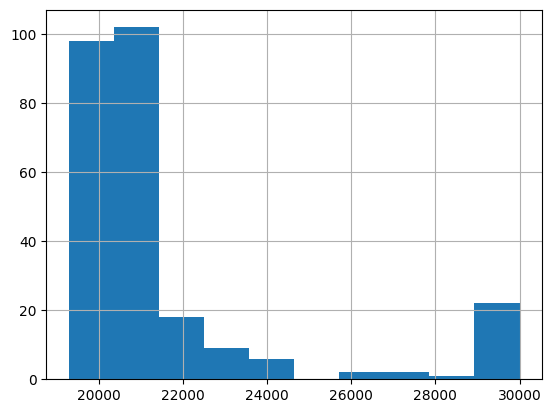

In [107]:
hyperdf_backwards[hyperdf_backwards['Mean Test MAE'] <= 1e+11]['Mean Test MAE'].hist()

In [126]:
hyperdf[hyperdf['Mean Test MAE'] <= 5e+12].sort_values('Mean Test MAE').round()

,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
8,"Index(['OverallQual', 'OverallCond', 'ExterQua...",51,20458.0,646.0,21578.0,958.0,32829.0,1767.0,35339.0,7288.0,all continuous and ordinal,5,"[20868.521786576137, 20630.99268969516, 20394....","[21017.799085718852, 21716.91604140758, 21954....","[34608.3403496537, 32940.37976496939, 32841.81...","[27621.46642685809, 35039.15781654459, 36001.9...",LinearRegression()
9,"Index(['OverallQual', 'GrLivArea', 'ExterQual'...",10,23487.0,435.0,23858.0,1124.0,36525.0,1444.0,37435.0,6058.0,top 10 features by correlation,5,"[23926.510051139394, 23492.653993932792, 23409...","[22236.15590435126, 24521.373549107302, 23798....","[38247.294098794904, 36441.23648663021, 36236....","[29791.460367925145, 37875.09972239045, 39301....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,25003.0,1952.0,39440.0,2212.0,41225.0,8078.0,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,25301.0,1144.0,36742.0,1206.0,37205.0,4809.0,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,28913.0,1365.0,42409.0,1010.0,42587.0,4178.0,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()


In [125]:
hyperdf[hyperdf['Mean Test RMSE'] <= 5e+12].sort_values('Mean Test RMSE').round()

,Features,# of features,Mean Train MAE,Std Train MAE,Mean Test MAE,Std Test MAE,Mean Train RMSE,Std Train RMSE,Mean Test RMSE,Std Test RMSE,Notes,Folds,Train MAE,Test MAE,Train RMSE,Test RMSE,Model Type
8,"Index(['OverallQual', 'OverallCond', 'ExterQua...",51,20458.0,646.0,21578.0,958.0,32829.0,1767.0,35339.0,7288.0,all continuous and ordinal,5,"[20868.521786576137, 20630.99268969516, 20394....","[21017.799085718852, 21716.91604140758, 21954....","[34608.3403496537, 32940.37976496939, 32841.81...","[27621.46642685809, 35039.15781654459, 36001.9...",LinearRegression()
5,"Index(['OverallQual', 'OverallCond', 'ExterQua...",24,24835.0,401.0,25301.0,1144.0,36742.0,1206.0,37205.0,4809.0,all ordinal,5,"[25208.369915157284, 24815.445125149825, 24186...","[23835.94225319929, 25532.52953048413, 26777.4...","[38156.14653249388, 37105.09884631882, 35541.4...","[31331.414093767857, 36013.39873996856, 42198....",LinearRegression()
9,"Index(['OverallQual', 'GrLivArea', 'ExterQual'...",10,23487.0,435.0,23858.0,1124.0,36525.0,1444.0,37435.0,6058.0,top 10 features by correlation,5,"[23926.510051139394, 23492.653993932792, 23409...","[22236.15590435126, 24521.373549107302, 23798....","[38247.294098794904, 36441.23648663021, 36236....","[29791.460367925145, 37875.09972239045, 39301....",LinearRegression()
4,"Index(['LotArea', 'YearBuilt', 'YearRemodAdd',...",27,24043.0,681.0,25003.0,1952.0,39440.0,2212.0,41225.0,8078.0,all numerical/continuous,5,"[24304.993374461203, 24301.630413812294, 24059...","[24943.183426942433, 24447.70999458347, 23177....","[41178.04632506182, 39723.344982177194, 40211....","[34526.219038501855, 40822.48135062879, 38750....",LinearRegression()
3,"Index(['OverallQual', 'GrLivArea'], dtype='obj...",2,28758.0,375.0,28913.0,1365.0,42409.0,1010.0,42587.0,4178.0,2 highest correlated features,5,"[29184.44455190781, 28610.965496216086, 28384....","[27112.360859175325, 29629.550895243145, 29304...","[43716.161155878486, 42333.18113753699, 41752....","[37003.44813403181, 42963.793999464055, 45636....",LinearRegression()
2,"Index(['OverallQual'], dtype='object')",1,33723.0,622.0,33766.0,2017.0,48565.0,1108.0,48493.0,4390.0,baseline using single most correlated feature,5,"[34117.10336130585, 33290.297298534904, 32920....","[32087.026266832185, 35617.89568102952, 36148....","[49840.22992041868, 48617.94154897005, 46851.4...","[43226.91783631449, 48486.47097996885, 55105.9...",LinearRegression()
1,"Index(['GarageYrBlt_isna', 'MasVnrArea_isna', ...",6,40997.0,741.0,41460.0,1846.0,58856.0,1294.0,59417.0,5208.0,Numerical features with smart approach,5,"[41422.64043995177, 40287.3146661194, 40494.79...","[40183.65547804687, 42768.655915726864, 42732....","[60107.86726986333, 58639.82850941593, 57685.6...","[54210.8930157506, 60584.7240989845, 64172.229...",LinearRegression()
0,"Index(['MasVnrArea', 'LotFrontage'], dtype='ob...",2,50918.0,719.0,51026.0,2418.0,68772.0,1144.0,68911.0,4685.0,Numerical features with naive approach,5,"[51374.920052864305, 49833.777504480895, 50630...","[49139.05525895495, 54376.191779954854, 52518....","[69990.74915738498, 67730.88469327173, 68081.9...","[64014.98287924205, 73129.51171339606, 71959.4...",LinearRegression()


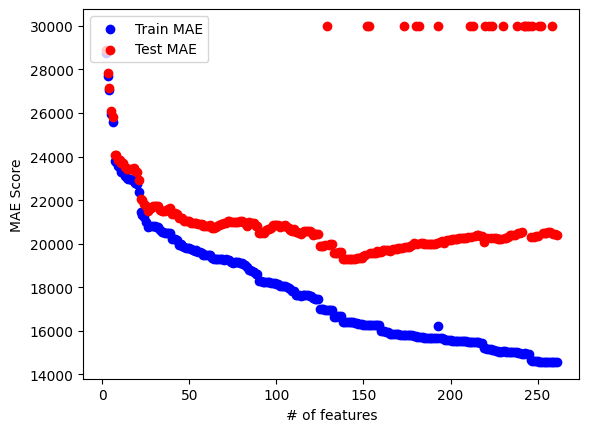

In [110]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

metric = "MAE"

# Plot the data
plt.scatter(hyperdf_backwards["# of features"],
            hyperdf_backwards["Mean Train " + metric], color="blue",
            label="Train " + metric)
plt.scatter(hyperdf_backwards["# of features"],
            hyperdf_backwards["Mean Test " + metric], color="red",
            label="Test " + metric)

plt.legend(loc=2)

# Add labels to the axes
plt.xlabel("# of features")
plt.ylabel(metric + " Score")

# Show the plot
plt.show()

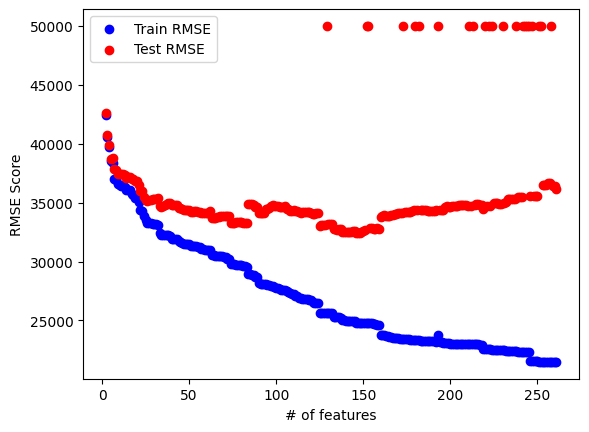

In [111]:
metric = "RMSE"

# Plot the data
plt.scatter(hyperdf_backwards["# of features"],
            hyperdf_backwards["Mean Train " + metric], color="blue",
            label="Train " + metric)
plt.scatter(hyperdf_backwards["# of features"],
            hyperdf_backwards["Mean Test " + metric], color="red",
            label="Test " + metric)

plt.legend(loc=2)

# Add labels to the axes
plt.xlabel("# of features")
plt.ylabel(metric + " Score")

# Show the plot
plt.show()

- Seems like anywhere from 75 to 150 features will be good.

- Let's go with 75 for now

In [112]:
model = LinearRegression()

In [113]:
# Take top 75 features
feats = sorted_cor[-75:]

# X final
Xf = X[feats].copy()

model.fit(Xf, y)

LinearRegression()

In [114]:
# define a series which is the min/max range of each feature in Xf

mm_range = Xf.max() - Xf.min()

In [116]:
# create dataframe for raw and transformed coefficients

coefs = pd.DataFrame(model.coef_, index=Xf.columns)
coefs.columns = ['Raw Coefficients']
coefs.sort_values(by='Raw Coefficients', ascending=False)


,Raw Coefficients
RoofMatl_WdShngl,84881.432225
Neighborhood_NoRidge,50738.429555
Neighborhood_StoneBr,43471.394891
Neighborhood_NridgHt,34292.742498
FireplaceQu_Ex,28442.187657
SaleType_New,28062.408465
GarageType_BuiltIn,15222.245872
GarageType_Detchd,14059.984188
GarageType_Attchd,13151.671271
MasVnrType_None,11651.044806


In [123]:
# transformed weight vec

coefs['TWV'] = coefs['Raw Coefficients'].abs() / mm_range

coefs.sort_values(by='TWV', ascending=False)


,Raw Coefficients,TWV
GarageYrBlt_isna,-166673.546365,166673.546365
GarageType_nan,-166673.546365,166673.546365
RoofMatl_WdShngl,84881.432225,84881.432225
Neighborhood_NoRidge,50738.429555,50738.429555
Neighborhood_StoneBr,43471.394891,43471.394891
Neighborhood_NridgHt,34292.742498,34292.742498
FireplaceQu_Ex,28442.187657,28442.187657
SaleType_New,28062.408465,28062.408465
GarageType_BuiltIn,15222.245872,15222.245872
Neighborhood_Edwards,-14565.550377,14565.550377


# Conclusion

- Lots of things to take away from this:
  - we chose 75 features as too many more started to lead to overfitting *with this particular data set*, if we had more rows of observations we could likely include more features, somewhere around double.
  - We were able to predict home prices *within this data set* accurately with a standard deviation of \$33k on the train and \$35k on the test set.
  - Also if we had more features we could look at doing some additional feature engineering to get more valuable features via target encoding.
  - We could also look at using more sophisticated models.